<font size="5"> **Image classification using CNN.**

Goal of this project was to create and train convolutional neural networks to the task of image classification.

Dataset that was used contains over 26 000 images divided into 10 classes: butterfly, cat, chicken, cow, dog, elephant, horse, sheep, spider, squirrel (source: https://www.kaggle.com/datasets/alessiocorrado99/animals10). Original dataset was using spain names for classes that were manually changed to english later on.

Classes are not balanced so to make sure that created CNN is not overfitted for those with more images I have used weights to minimalise this effect.

In [1]:
#importing packages that will be used in project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

D:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#setting data directory to the animals dataset that is in the same folder as notebook with code
data_dir = 'animals/'

In [3]:
os.path.exists(data_dir) #checking if path to animals exists - should show True

True

In [4]:
#finding out classes names from directory (folder names) and number of classes
class_names = sorted(os.listdir(data_dir))
n_classes = len(class_names)

#printing class_names and n_classes
print(f'Classes in dataset: {class_names}')
print(f'There are {n_classes} classes in dataset')

Classes in dataset: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
There are 10 classes in dataset


In [5]:
#creating dictionary with class names and number of images for every class and printing their pairs
#as we can see classes are not even and some of them contains significantly more images than others
number_of_images_in_classes = [len(os.listdir(data_dir + f'{class_name}/')) for class_name in class_names]

number_of_images_in_classes_dict = {class_names[i]: number_of_images_in_classes[i] for i in range(len(class_names))}

print(number_of_images_in_classes_dict)


{'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


<BarContainer object of 10 artists>

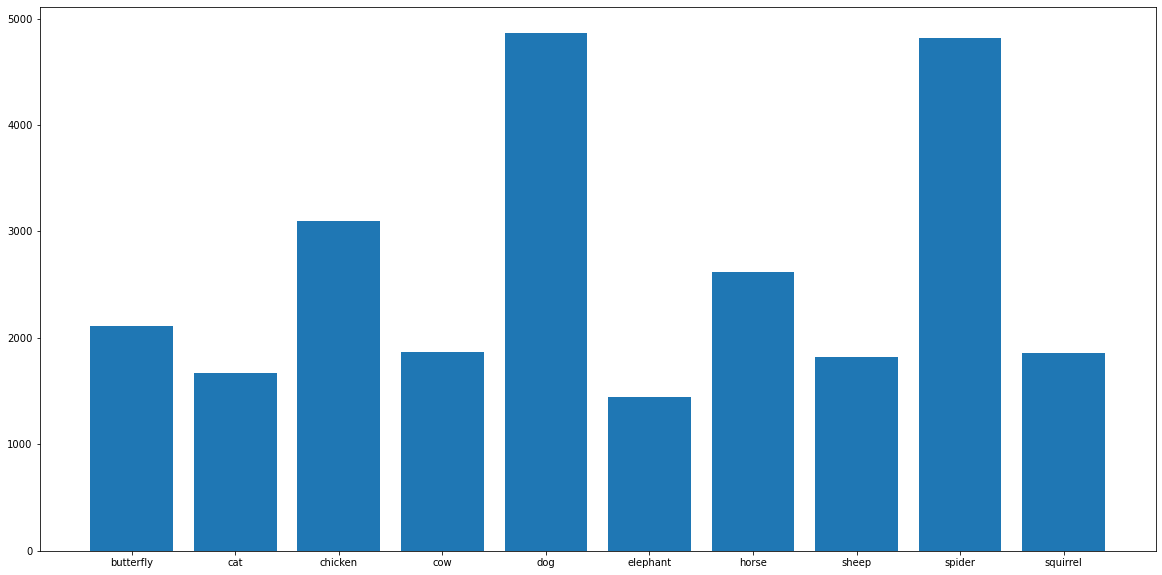

In [6]:
#putting number_of_images_in_classes_dict into graphic form of bar plot
plt.figure(figsize=(20,10))

plt.bar(number_of_images_in_classes_dict.keys(), number_of_images_in_classes_dict.values())

In [7]:
#creating data flow for images from folders in animals folder (classes)
#I have decided to use ImageDataGenerator and make validation split equal to 0.2 so that CNN will be validated on 20% of the dataset


h, w = 100, 100 #setting height, width to 100x100
batch_size = 32 #setting batch size to 32

data_flow_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2) #data flow with rescaled images and validation split set to 0.2

#train_data_flow and valid_data_flow refers to training and validation data that will be used for model training and validation later on

train_data_flow = data_flow_generator.flow_from_directory(data_dir,
                                                          target_size=(h, w),
                                                          batch_size=batch_size,
                                                          class_mode="categorical",
                                                          subset="training",
                                                          shuffle=True,
                                                          seed=123)
                                                                        

valid_data_flow = data_flow_generator.flow_from_directory(data_dir,
                                                      target_size=(h, w),
                                                      batch_size=batch_size,
                                                      class_mode="categorical",
                                                      subset="validation",
                                                      shuffle=True,
                                                      seed=123)



Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


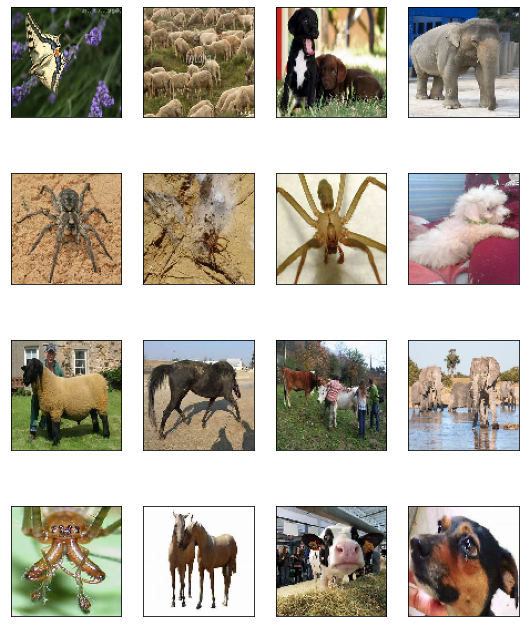

In [8]:
#let's see few example of images from dataset in 4x4 subplot form in color

list_of_example_images = []
n_col_in_plt = 4
n_row_in_plt = 4

for images,labels in next(zip(train_data_flow)):
  for i in range(16):
    list_of_example_images.append(images[i])

list_of_example_images = np.array(list_of_example_images)

plt.figure(figsize=(1.8 * n_col_in_plt, 2.4 * n_row_in_plt))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

for i in range(n_row_in_plt * n_col_in_plt):
    plt.subplot(n_row_in_plt, n_col_in_plt, i + 1)
    plt.imshow(list_of_example_images[i][:,:,:], cmap=None)
    plt.xticks(())
    plt.yticks(())
    
plt.show()

In [9]:
#creating class dictionary with numerical value assigned to every class

class_dict = train_data_flow.class_indices

print(class_dict)

{'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}


In [10]:
#below code will allow us to see how many images are assigned to every class
#but this time with split between train and validation data

counter_train_data = Counter(train_data_flow.classes)
counter_val_data = Counter(valid_data_flow.classes)
print(counter_train_data.items())
print(counter_val_data.items())

dict_items([(0, 1690), (1, 1335), (2, 2479), (3, 1493), (4, 3891), (5, 1157), (6, 2099), (7, 1456), (8, 3857), (9, 1490)])
dict_items([(0, 422), (1, 333), (2, 619), (3, 373), (4, 972), (5, 289), (6, 524), (7, 364), (8, 964), (9, 372)])


In [11]:
#this function will allow us to create barplots containing data gathered in previous cell
#it takes 2 arguments, data is pointing at values we will use to create plots
#train_or_valid is taking string value that will allow us to print whether we are looking
#at training or validation data - it will be visible in plot title


def barplot_flow(data, train_or_valid):
    
    labels = [i for i, j in data.items()]
    values = [j for i, j in data.items()]
    
    x = np.arange(0, 10, 1)
    y =np.arange(0, 5001, 1000)
    
    plt.figure(figsize=(20,10))
    plt.bar(labels, values)
    plt.xticks(x)
    plt.yticks(y)
    plt.xlabel('Class label')
    plt.ylabel('Number of observations')
    plt.title(f'Number of observations per class in {train_or_valid} data')
    
    plt.show()



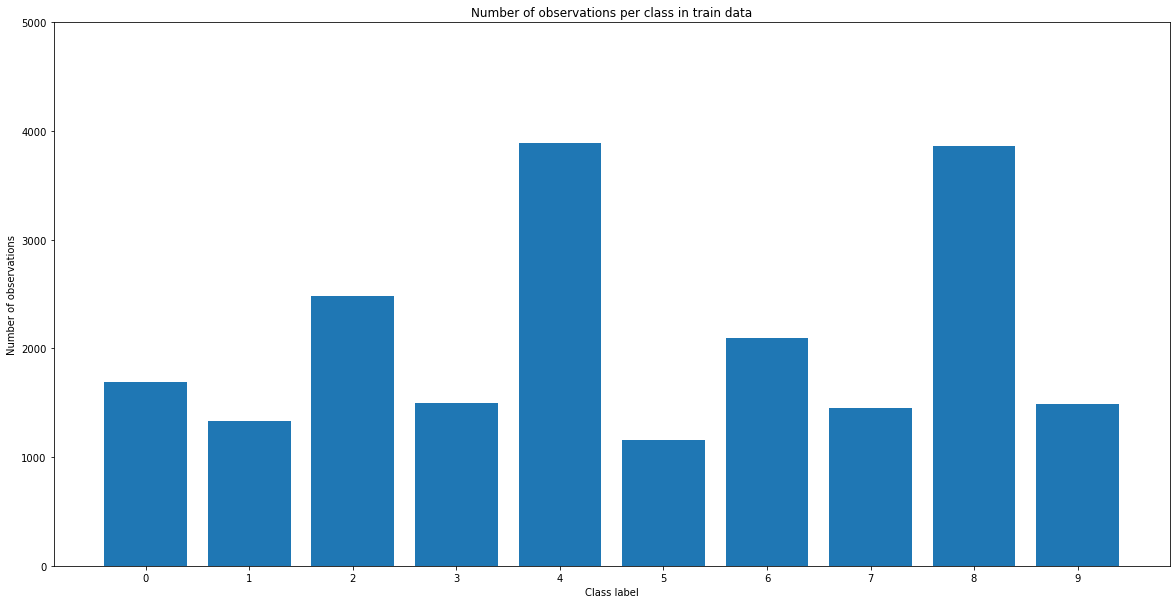

In [12]:
barplot_flow(counter_train_data, "train")

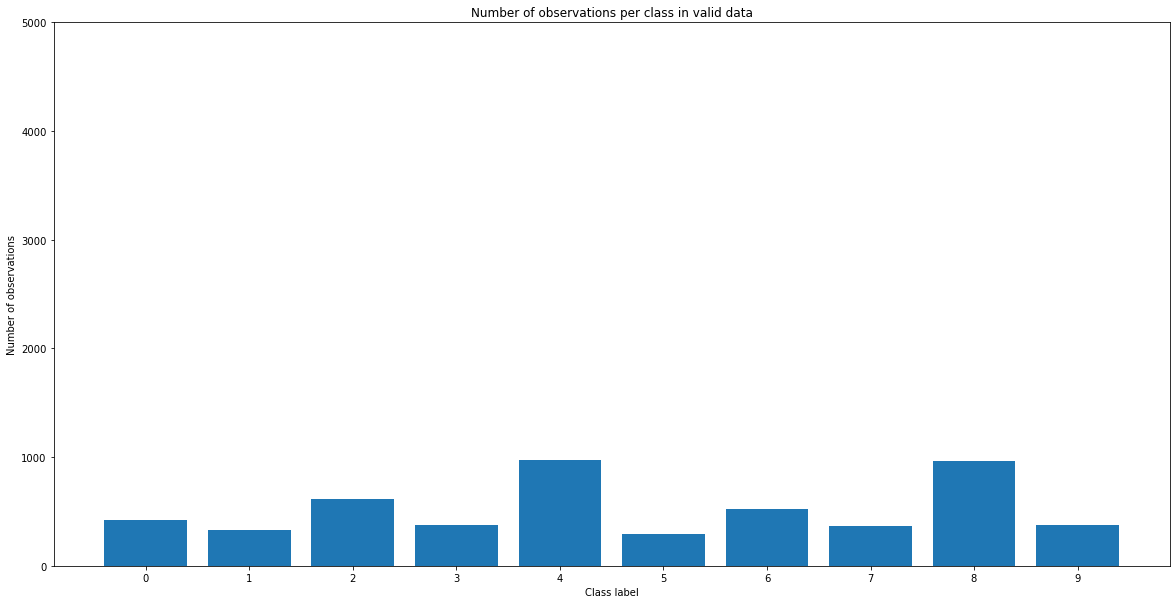

In [13]:
barplot_flow(counter_val_data, "valid")

In [14]:
#below function will be used to create weights for all of the classes
#this should has positive effect on training process for there will be
#value that should ease bigger number of images in classes that dominates in dataset

def weight_generator(data):
    class_weights = {}
    
    labels = [i for i, j in data.items()]
    values = [j for i, j in data.items()]
    
    total_samples = sum(values)
    num_classes = len(labels)
  
    for label, count in zip(labels, values):
        class_weight = total_samples / (num_classes * count)
        class_weights[label] = class_weight 
        
    return class_weights
   

In [15]:
#below we are printing results of our function for training data

class_weights = weight_generator(counter_train_data)

print(class_weights) 

{0: 1.2394674556213017, 1: 1.569063670411985, 2: 0.8449778136345301, 3: 1.4030140656396517, 4: 0.5383448984836803, 5: 1.810458081244598, 6: 0.9979514054311577, 7: 1.4386675824175825, 8: 0.5430904848327716, 9: 1.4058389261744966}


In [16]:
#creating EarlyStopping that will finish training process after 3 epochs since val_accuracy increased more than 0.001

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.001)

Below is the main function of the project that creates Sequential model of our CNN.

It was probably part of the code that was changed the most in pursue of higher accuracy values. Actions that were taken allowed it to grow from initial val_accuracy of around 0.4 to around 0.75.

Function is taking several arguments such as train and validation datasets, used layers activation, final layer activation, used loss function, optimizer, number of epochs and class weights.

Default values are not the best options so the function will be called later on with several of the arguments changed.



In [17]:
def creating_cnn(train_data, validation_data, layers_activation ="relu", 
                 final_layer_activation = "softmax",loss_function="categorical_crossentropy",
                 optimizer = "adam", epochs=10, class_weight=class_weights):
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), activation=layers_activation, input_shape=(h, w, 3))) 
    model.add(MaxPool2D((2,2)))
    
    model.add(Conv2D(64, (3,3), activation=layers_activation))
    model.add(MaxPool2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation=layers_activation))
    model.add(MaxPool2D((2,2)))
    
    model.add(Conv2D(128, (3,3), activation=layers_activation))
    model.add(MaxPool2D((2,2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation=layers_activation))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation=layers_activation))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation=final_layer_activation))
    
    model.summary()
    
    model.compile(loss=loss_function, 
              optimizer=optimizer, 
              metrics=["accuracy"])
    
    model_history = model.fit(train_data,  
          validation_data=validation_data,
          class_weight = class_weight,
          epochs=epochs,
          callbacks=[early_stopping])
    
    
    #this part of the function will create plot that will show changes of training and validation datasets accuracy during learning process
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    max_val_acc = np.max(model_history.history['val_accuracy']) #variable containing highest val_accuracy reached by model
    
    print('-----------------------------------------------------------------')
    print("\n")
    print(f"Highest validation accuracy that was reached by CNN is {max_val_acc}.")
    

In [18]:
# creating_cnn(train_data=train_data_flow, validation_data=valid_data_flow)

In [19]:
# creating_cnn(train_data=train_data_flow, validation_data=valid_data_flow, layers_activation= tf.keras.layers.LeakyReLU(alpha=0.01), epochs=15)

In [20]:
# creating_cnn(train_data=train_data_flow, validation_data=valid_data_flow, layers_activation= tf.keras.layers.LeakyReLU(alpha=0.03), epochs=15)

In [21]:
# creating_cnn(train_data=train_data_flow, validation_data=valid_data_flow, layers_activation= tf.keras.layers.LeakyReLU(alpha=0.03), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008), epochs = 15)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

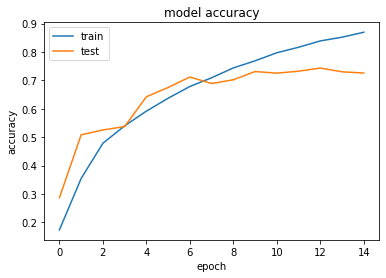

-----------------------------------------------------------------


Highest validation accuracy that was reached by CNN is 0.7435015439987183.


In [22]:
creating_cnn(train_data=train_data_flow, validation_data=valid_data_flow, layers_activation= tf.keras.layers.LeakyReLU(alpha=0.03), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), epochs = 15)